# HW08

## Exercises to practice pandas, data analysis, regression and classification

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LFWUtils
from data_utils import LinearRegression, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [4]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [5]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [6]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

Min values:
 age                     17.0
gender                   0.0
height                  56.0
weight                   0.0
span                  1323.0
stature               1409.0
ear.breadth             25.0
ear.length              46.0
ear.protrusion          13.0
foot.breadth            77.0
foot.length            198.0
hand.breadth            67.0
hand.length            145.0
hand.palm               88.0
head.height            206.0
head.circumference     502.0
dtype: float64
Max values:
 age                     58.0
gender                   1.0
height                  94.0
weight                 321.0
span                  2121.0
stature               1993.0
ear.breadth             46.0
ear.length              81.0
ear.protrusion          34.0
foot.breadth           126.0
foot.length            323.0
hand.breadth           105.0
hand.length            239.0
hand.palm              140.0
head.height            295.0
head.circumference     635.0
dtype: float64
Average values:


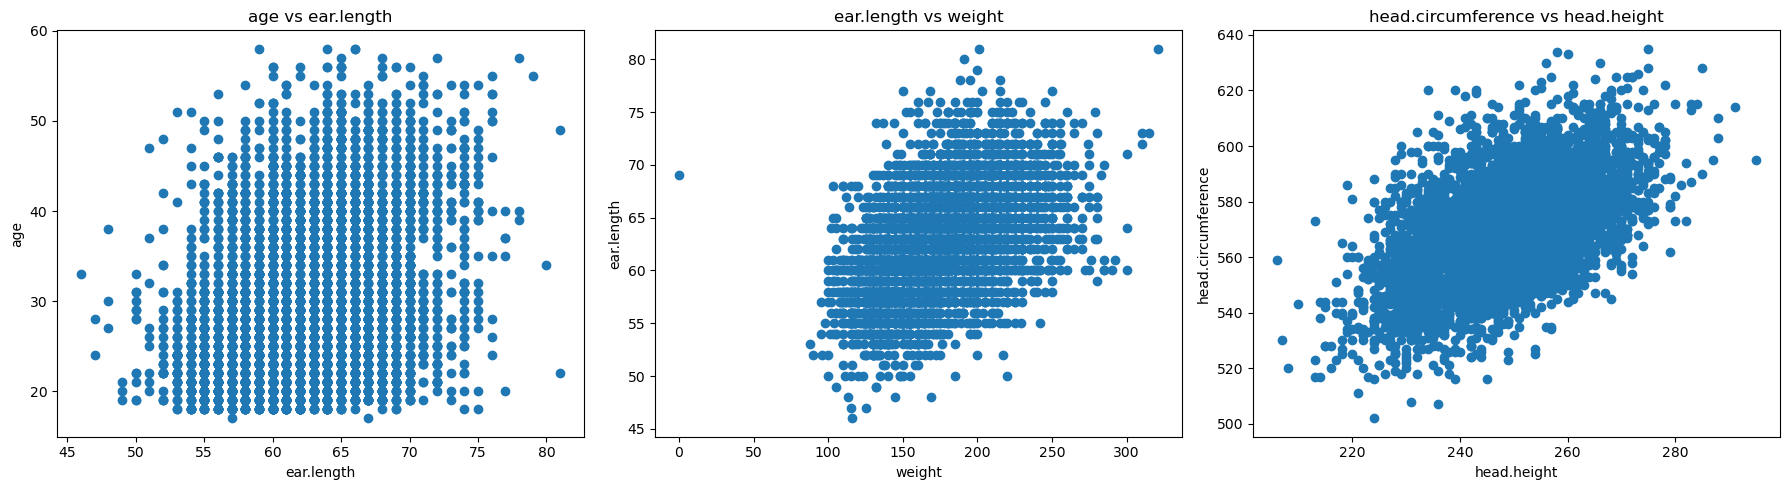

In [7]:
# Work on Data Exploration here

### Encode non-numerical features
ansur_encoder = OrdinalEncoder()
ansur_df["gender"] = ansur_encoder.fit_transform(ansur_df[["gender"]])

## 1. Print min, max, avg
print("Min values:\n", ansur_df.min())
print("Max values:\n", ansur_df.max())
print("Average values:\n", ansur_df.mean())

### Normalize all data
ansur_scaler = StandardScaler()
ansur_scaled_df = ansur_scaler.fit_transform(ansur_df)

## 2. Print Covariances
cov_matrix = ansur_df[["age", "ear.length", "head.circumference"]].cov()
print("Covariance matrix:\n", cov_matrix)

## 3. Plot features most correlated to age, ear length and head circumference
correlation_matrix = ansur_df.corr()
most_correlated_features = {
    "age": correlation_matrix["age"].abs().sort_values(ascending=False).index[1],
    "ear.length": correlation_matrix["ear.length"].abs().sort_values(ascending=False).index[1],
    "head.circumference": correlation_matrix["head.circumference"].abs().sort_values(ascending=False).index[1]
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (feature, correlated_feature) in zip(axes, most_correlated_features.items()):
    ax.scatter(ansur_df[correlated_feature], ansur_df[feature])
    ax.set_xlabel(correlated_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {correlated_feature}")

plt.tight_layout()
plt.show()

### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:hotpink;">The correlation of ear length to age is low but tends towards longer past age 45. Weight does have a stronger correlation with ear length. As people have a weight under 150, the have a possibility of shorter ears than is highly unlikely with someone at a weight above 200. People with a weight above 200 have a averagely longer ear length. Head height does strongly correlate with head circumference. The feature most correlated to ear length does have ear length as its most correlated pair.</span>

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

Training error: 0.7584338370549019


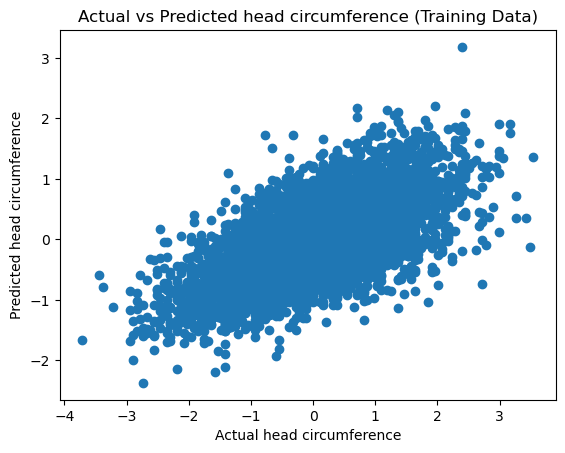

In [8]:
# Work on Regression Model here

## Separate outcome variable and input features
X_train = ansur_scaled_df.drop(columns=["head.circumference"])
y_train = ansur_scaled_df["head.circumference"]

## Create a regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

## Measure error on training data
y_train_pred = regression_model.predict(X_train)
train_error = regression_error(y_train, y_train_pred)
print(f"Training error: {train_error}")

## Plot predictions and interpret results
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual head circumference")
plt.ylabel("Predicted head circumference")
plt.title("Actual vs Predicted head circumference (Training Data)")
plt.show()

In [9]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur-test.json"
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

/Users/raycogliano/Desktop/ML Class/WK03/.conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


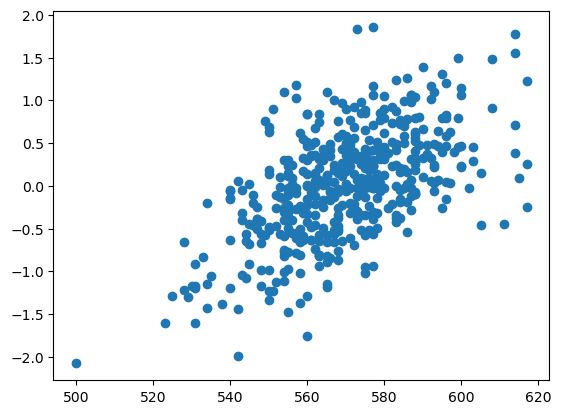

In [10]:
## Run model on test data
X_test = ansur_test_scaled_df.drop(columns=["head.circumference"])

## Measure error on test data
y_test_pred = regression_model.predict(X_test)

## Plot predictions and interpret results
plt.scatter(ansur_test_df["head.circumference"], y_test_pred)

### Interpretation

<span style="color:hotpink;">
How well does your classifier perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">The classifier has a low error rate of "Training error: 0.7584338370549019". it's not perfect but the predicted vs actual has a positive correlation. I could improve it by incorporating comparison of other physical measurements to have a more accurate prediction. The model is more inaccurate with very large or very small head circumferences.</span>

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [11]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [12]:
# TODO: check and see what is inside the list here
train_files

['03-05.jpg',
 '28-69.jpg',
 '26-50.jpg',
 '07-75.jpg',
 '23-60.jpg',
 '23-48.jpg',
 '18-21.jpg',
 '12-54.jpg',
 '15-49.jpg',
 '12-40.jpg',
 '15-48.jpg',
 '08-19.jpg',
 '27-05.jpg',
 '18-34.jpg',
 '11-04.jpg',
 '18-20.jpg',
 '09-65.jpg',
 '07-48.jpg',
 '19-60.jpg',
 '19-74.jpg',
 '10-50.jpg',
 '19-48.jpg',
 '25-14.jpg',
 '19-62.jpg',
 '13-03.jpg',
 '23-63.jpg',
 '08-27.jpg',
 '01-17.jpg',
 '06-36.jpg',
 '06-37.jpg',
 '27-12.jpg',
 '02-47.jpg',
 '17-66.jpg',
 '03-13.jpg',
 '10-90.jpg',
 '22-36.jpg',
 '10-43.jpg',
 '09-62.jpg',
 '18-33.jpg',
 '27-02.jpg',
 '08-22.jpg',
 '01-07.jpg',
 '06-32.jpg',
 '23-73.jpg',
 '24-52.jpg',
 '25-38.jpg',
 '19-64.jpg',
 '10-40.jpg',
 '28-78.jpg',
 '21-60.jpg',
 '09-75.jpg',
 '24-44.jpg',
 '24-50.jpg',
 '02-40.jpg',
 '05-49.jpg',
 '27-15.jpg',
 '06-30.jpg',
 '01-39.jpg',
 '08-35.jpg',
 '08-21.jpg',
 '12-44.jpg',
 '01-38.jpg',
 '18-31.jpg',
 '23-64.jpg',
 '09-48.jpg',
 '13-10.jpg',
 '13-04.jpg',
 '22-43.jpg',
 '10-26.jpg',
 '24-22.jpg',
 '08-53.jpg',
 '08-5

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [13]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [14]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print(label_data[:5])
print(train_files[:5])

[2, 23, 21, 5, 18]
['03-05.jpg', '28-69.jpg', '26-50.jpg', '07-75.jpg', '23-60.jpg']


The labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

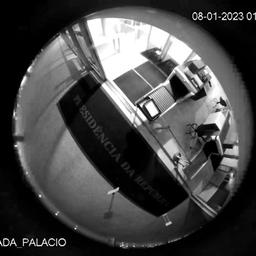

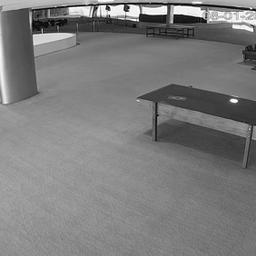

In [15]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

And now might not be a bad time to peek into the `data/image/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [16]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [17]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,2
1,102,102,102,103,103,104,104,104,104,104,...,143,135,135,132,129,130,133,131,126,23
2,95,95,95,96,96,97,97,97,97,97,...,108,107,102,97,95,97,100,101,101,21
3,56,56,56,55,56,61,67,72,66,62,...,165,168,170,173,176,177,178,177,175,5
4,188,188,188,188,188,188,188,188,186,186,...,179,174,177,181,184,185,185,183,181,18


### Test Files

If that worked, repeat the process for the test files inside the `./data/image/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [ ]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/image/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
print(len(test_files))
print(test_files[:5])

test_pixel_data = []

# TODO: loop over files and load their pixels into a list
for fname in test_files:
  img = open_image(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(img.pixels)

# TODO: load into DataFrame (this might take 20 - 30 seconds)
test_df = pd.DataFrame(test_pixel_data)

1573
['7446006.jpg', '6844827.jpg', '14590409.jpg', '7330491.jpg', '8569853.jpg']


Check the `DataFrame`

In [22]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,104,105,107,108,107,106,104,103,108,108,...,188,199,205,186,173,177,187,190,187,185
1,168,179,194,213,233,244,241,231,238,239,...,96,106,94,86,87,96,98,91,90,97
2,122,122,122,123,123,124,124,124,123,123,...,159,157,151,149,147,145,143,144,145,147
3,172,185,192,205,236,251,239,224,240,242,...,101,100,97,89,89,98,98,90,87,92
4,132,132,132,133,133,134,134,134,134,134,...,149,147,147,147,146,145,145,144,143,143


Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [38]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error*
7. Run model on test data, measure error*, plot predictions, interpret results

*: we can use the same `regression_error()` function we used above to measure the error of our classifier model, but this could lead to $2$ issues. First, we don't have labels for the images in the test dataset, and second, the regression error reported might be higher than it actually is because an image with label $0$ that gets mislabeled as $5$ will count as being more wrong than if it was mislabeled $2$. And we don't want that. We just want to get the percentage of classifications that our model gets correctly.

To simplify calculating the classification accuracy we can use the `CamUtils.classification_accuracy()` function. This function takes $2$ parameters, a list of files and a list of predictions. It will work with the test and train datasets and will calculate a more accurate accuracy value than the one returned by `regression_error()`.

In [39]:
# TODO: create a brand new classifier
classifier = RandomForestClassifier()
# TODO: fit the model
classifier.fit(train_features, out_features)
# TODO: run predictions
train_predictions = classifier.predict(train_features)
# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [40]:
# TODO: run predictions on test data
test_predictions = classifier.predict(test_features)
# TODO: measure classification accuracy
CamUtils.classification_accuracy(test_files, test_predictions)

0.645899554990464

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data<br>
How does the choice of pixels affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:hotpink;">I think this classifer can be improved using a higher feature count. In my testing 10 features to 50 to 100 to 500 greately improved the classification accuracy. ex: 500 features = 0.9014 accuracy </span>